# Aufgabenstellung

Es soll ein Model erstellt werden, welches einem Benutzer bei Eingabe einer Frage ähnliche, bereits vorhanden Fragen vorstellt.
Je präsizer der Bentuzer die Frage formuliert, umso präziser sollen auch die Vorhersagen sein.

# Lösung
## Betrachtung des Datensatzes
Der Datensatz beinhaltet neben den README-Dateien 3 CSV-Dateien

### Trainings-Datensatz
Der Trainingsdatensatz ist in der Datei 'training.csv' enthalten.
Der Datensatz enthält insgesamt 5 Attribute pro Datum.
Eine allgemeine 'id', eine 'qid1' & 'qid2' für die jeweilige Frage.
Schlussendlich folgen die beiden Fragen sowie die Spalte 'is_duplicate', bei welcher zwei Fragen mit gleicher Intention mit dem Label 1 markiert sind.

#### Aussortieren nicht benötigter Parameter

Die Attribute 'question1', 'question2' und 'is_duplicate' werden auf jedenfall benötigt, da in dieser die Fragen sowie das Klassiefizierungslabel enthalten sind

Im zu trainierenden Modell soll rein der textliche Inhalt der Fragen von Bedeutung sein. Aus diesem Grund werden beim Einlesen der Daten die Attribute 'id', 'qid1' & 'qid2' nicht mit geladen.

#### Vorverarbeitung der Daten
Im geladenen Dataframe werden die Datensätze entfernet, welche in einer der Attribute ein NaN-Value besitzen. Dies ist nötig, da aus diesen Datensätzen keinen sinnvollen Rückschlüsse gezogen werden können.

Außerdem werden Duplikate entfernt, da ein Training des selben Datensatzen nicht zur Verbesserung des Modelles beiträgt.


In [1]:
# https://www.kaggle.com/nkaps98/quora-question-pairs-glove-lstm
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Multiply, Flatten, Dropout, Dense, LSTM, SimpleRNN, Bidirectional, GRU
from sklearn.model_selection import train_test_split
plt.rcParams["figure.figsize"] = 15,15
tf.random.set_seed(35)

df_train = pd.read_csv(
    "./fragen/train.csv",
    usecols = ['question1', 'question2', 'is_duplicate'],
    encoding = 'utf-8'
)

df_train.dropna(inplace=True)
df_train.head()

,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


Damit der Text präziser verarbeitet werden kann, werden außerdem alle Buchstaben in lowercase umgewandelt

In [2]:
df_train = df_train.applymap(lambda s: s.lower() if type(s) == str else s)

### Visualisieren der Trainingsdaten
#### Verteilung der Labels in den Trainingsdaten

Im folgenden wird die Verteilung der Label in den Trainingsdaten mit Hilfe eines Balkendiagrammes visualisiert.

Text(0.5, 1.0, 'Number of elements found in dataset')

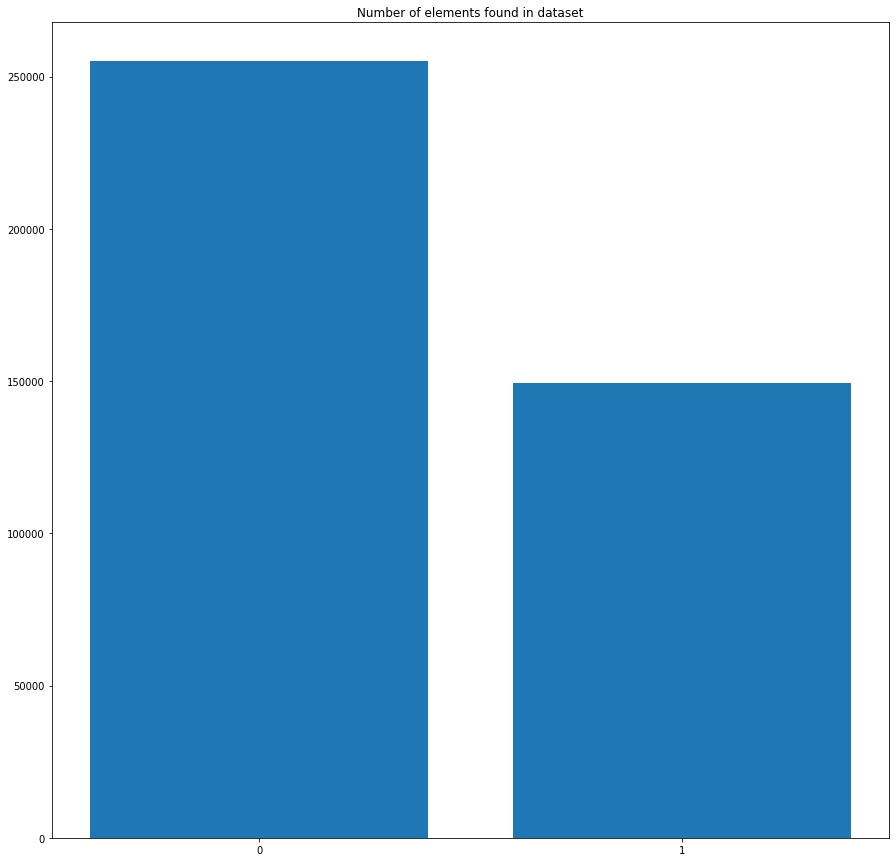

In [3]:
fig, ax = plt.subplots()
label_dist = df_train.is_duplicate.value_counts()

ax.bar([0,1],label_dist)
ax.set_xticks([0,1], labels=[0,1])
ax.set_title('Number of elements found in dataset')

#### Anzahl der Duplikate

In [4]:
print(df_train.duplicated(keep='first').sum())
df_train.groupby(df_train.columns.tolist(),as_index=False).size()

341


,question1,question2,is_duplicate,size
0,can i pay with a debit card on paypal?,can you transfer paypal funds onto a debit car...,0,1
1,does new york state have a flagship university?,how can the new york state be fixed?,0,1
2,failures haunt me all the time.how do i cope up?,what can help me cope up with my failure?,1,1
3,how do i make the time lapse images using an ...,how do i make time-lapse photography?,0,1
4,i didn't file a police report for a car accid...,why don't i get the money i paid for a year wo...,0,1
...,...,...,...,...
403941,你说我说中文会不会有人看得懂. what does this sentence mean?,what does this sentence mean?,0,1
403942,格局how to translate?,how do you translate this?,0,1
403943,格局how to translate?,"how would you translate ""一百回""?",0,1
403944,"黎权锋, help me make up an english name, thank yo...",would you want to help me come up with a name ...,0,1


In [5]:
label_dist[0] - label_dist[1]

105761

Es lässt sich beobachten, das circa 5/8 der Fragenpaare mit dem Label 0, also sinnlich nicht verwandt, versehen sind. Dies kann bei dem trainierten Modell dazu führen, dass das Model zuverlässiger bei der Erkennung von nicht gleichen Fragen als bei gleichen Fragen ist.

## Einlesen der Testdaten
Der Testdatensatz besteht aus zwei Dateien.
In der Datei `test.csv` befinden sich Fragenpaarungen, bestehend aus `question1` und `question2`.
Zuätzlich ist jede Fragenpaarung mit einer eindeutigen ID versehen, gekennzeichnet durch `test_id`.
Es werden analog zum Trainingsdatensatz Reihen mit einem NaN-Value entfernt, sowie alle Strings auf lowercase gesetzt.


In [6]:
test_data_raw = pd.read_csv(
    "./fragen/test.csv",
    usecols= ['test_id', 'question1', 'question2'],
    encoding='utf-8'
)
#u_test, c_test = np.unique(test_data_raw.test_id, return_counts=True)
#if len(u_test[c_test > 1]) == 0:
#    print("test_id is unique")

test_data_raw = test_data_raw.applymap(lambda s: s.lower() if type(s) == str else s)
test_data_raw.dropna(inplace=True)
test_data_raw.head()

/tmp/ipykernel_2757/695126534.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data_raw = pd.read_csv(


,test_id,question1,question2
0,0,how does the surface pro himself 4 compare wit...,why did microsoft choose core m3 and not core ...
1,1,should i have a hair transplant at age 24? how...,how much cost does hair transplant require?
2,2,what but is the best way to send money from ch...,what you send money to china?
3,3,which food not emulsifiers?,what foods fibre?
4,4,"how ""aberystwyth"" start reading?",how their can i start reading?


Zusätzlich zur Datei `test.csv`, gibt es eine Datei `sample_submission.csv`
Diese enthält zwei Attribute pro Reihe.
Die Spalte `test_id` lässt dabei vermuten, dass diese zugehörig zur entsprechenden Fragepaarung aus dem Testdatensatz sind
Die Spalte `is_duplicate` besitzt wahrscheinlich die selbe Funktionalität wie die entsprechende Spalte aus dem Trainingsdatensatz.

In [7]:
submission_data_raw = pd.read_csv(
    "./fragen/sample_submission.csv",
    usecols = ['test_id', 'is_duplicate']
)

submission_data_raw.dropna(inplace=True)
submission_data_raw.head()

,test_id,is_duplicate
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


Wie aus dem folgenden Codeabschnitt hervorgeht, stimmen die Attribute `test_id` der beiden Dateien in ihren Elementen überein.

In [8]:
u_sample, c_sample = np.unique(submission_data_raw.test_id, return_counts=True)
if len(u_sample[ c_sample > 0]) == 0 and u_sample == u_test:
    print("test_id is identical to the test dataset")

Im folgenden wird eine Betrachtung der Verteilung der Labels aus der Spalte `is_duplicate` durchgeführt.

In [9]:
submission_data_raw.is_duplicate.value_counts()

1    2345796
Name: is_duplicate, dtype: int64

Es ergibt sich, dass sämtliche Fragepaarung, zumindest laut der Datei `sample_submission.csv`, das Label 1 besitzen.
Dies ist in dem Sinne recht problematisch, da dadurch die Erkennung einer falschen Vorhersage nicht überprüft wird.

### Zusammenführen der beiden Dataframes
Im folgenden Code-Abschnitt werden die gewonnene Dataframes aus den beiden Dateien gemerged.
Der Merge erfolgt dabei anhand des Attributs `test_id`

In [10]:
test_data_merged_raw = test_data_raw.merge(submission_data_raw, left_on="test_id", right_on="test_id")

test_data_merged_raw.dropna(inplace=True)
test_data_merged_raw.drop_duplicates(inplace=True)
test_data_merged_raw.head()

test_data_merged_raw.is_duplicate.value_counts()

1    2345790
Name: is_duplicate, dtype: int64

Anschließend wird aus dem gemergten Dataframe die Spalte `is_duplicate` entfernt und in einer eigenen Variablen abgespeichert.

In [11]:
target_test = test_data_merged_raw.pop('is_duplicate')

## Aufteilung der Trainingsdaten in Trainings- und Validierungsdaten
Vom Trainingsdatensatz wird die Label-Spalte 'is_duplicate' abgespaltet

Der Trainingsdatensatz wird in Trainings- und Validierungsdaten aufgeteilt.

20% des Trainingsdatensatzes werden als Validierungsdatensatz abgespalten.

Für ein reproduzierbares Ergebnis wurden bei der Aufteilung des Datensatzes ein festgelegter Seed verwendet.

In [12]:
target = df_train.pop('is_duplicate')

xTrain, xValid, yTrain, yValid = train_test_split(df_train, target, test_size=0.2, random_state=35)
xTrain.head()

,question1,question2
283108,which are the best german universities for an ...,which are the best german universities for an ...
73636,i like being merchant navy?,are astronauts allowed to masturbate in space?
46418,what is the legal definition of a human being?...,what do men think about menstrual cycle?
11449,how can i handle having personal issues with m...,how do i take things my partner says less pers...
283432,"how cold can the gobi desert get, and how do i...","how cold can the gobi desert get, and how do i..."


## Erstellung eines Tokenizers

Um ein besseres Training zu ermöglichen, wird ein Tokenizer erstellt, welche die Wörter der Fragen einem Integer-Value zuordnet.
Der Tokenizer wird auf alle Fragen des nicht gesplitteten Trainingsdatensatzes angewandt.

Der Tokenizer wird nicht auf die Fragen des Testdatensatzes gefittet, da diese rein zur Evaluierung des finalen Modelles verwendet werden.

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(df_train.question1.values) + list(df_train.question2.values))

## Kodierung  und Anpassung der Form der Fragen
Die Fragen der gesplitteten Datensätzen werden mittels des erstellten Tokenizer kodiert, sprich der String zu einem Array aus Integer werden umgewandelt.

Damit die Fragen auch alle das gleiche Format besitzen, wird das Array anschließend auf eine Länge von 40 gestreckt.
Positionen, welche nicht durch die Interger-Werte der Wörter des vorherigen Stringes gefüllt wurden, werden mit dem Wert 0 gefüllt.

Es wird der Trainingsdaten, der Validierungsdatensatz und auch der Testdatensatz codiert.
Dies ist nötig, damit das Modell später die standardisierte Eingabe akzeptiert.
Bei der Evaluierung von Benutzer-Fragen muss eine Codierung dieser ebenfalls erfolgen.

In [14]:
def tokenizeQuestions(df_questions):
    tokenized_questions = tokenizer.texts_to_sequences(df_questions)
    return pad_sequences(tokenized_questions, maxlen = 36, padding = 'post')

In [15]:
q1_train = tokenizeQuestions(xTrain.question1)
q2_train = tokenizeQuestions(xTrain.question2)

q1_valid = tokenizeQuestions(xValid.question1)
q2_valid = tokenizeQuestions(xValid.question2)

q1_test = tokenizeQuestions(test_data_merged_raw.question1)
q2_test = tokenizeQuestions(test_data_merged_raw.question2)

In [16]:
word_index = tokenizer.word_index

#### Erstellung eines Dictionaries, welche später für das Finden von ähnlichen Fragen verwendet wird
Es wird ein Sammlung aller Fragen aus dem Trainingsdatensatz erstellt.
Dabei werden Dupliakte aussortiert, sodass jede Frage nur einmal vorhanden ist.

Diese Sammlung kann anschließend im späteren Verlauf zum Finden von ähnlichen Fragen verwendet werden.

In [17]:
completeQuestionsDict = np.unique(np.concatenate((q1_train, q2_train, q1_valid, q2_valid)), axis=0)

## Erstellung des Modelles
Das Model beinhaltet 2 Untermodelle. Die Outputs dieser Modellen werden im Lauf des Modelles zusammengefügt und weiter verarbeitet.

Die 2 Untermodelle werden benötigt, da die 2 verschiedenen Fragen 2 Modell-Inputs darstellen und jeweils entsprechend (vor)verarbeitet werden müssen.

#### Erstellung einem vorgefertigeten GloVe Model für das Embedding-Layer
Bei der Aufgabenstellung bietet es sich an, für die Gewichtung des Embedding-Layers ein vorgefertigtes Modell zu nehmen.
In dieser Ausführung wird dazu das GloVe-Modell der Standard-Univerity verwendet.
Es enthält 42B-Tokens, und einen Umfang von 1.9M Wörtern
https://github.com/stanfordnlp/GloVe

#### Download des GloVe-Models

In [18]:
url = "https://huggingface.co/stanfordnlp/glove/resolve/main/glove.42B.300d.zip"
dataset = tf.keras.utils.get_file("glove", url, extract=True)

#### Aulesen der Embeddings und Generierung der Gewichte

In [19]:
embeddings = {}
with open('./glove/glove.42B.300d.txt', encoding='utf-8') as f:
 for line in f:
    values = line.split(' ')
    embeddings[values[0]] = np.asarray(values[1:], dtype='float32')
 f.close()

In [20]:
weight_matrix = np.zeros((len(word_index)+1, 300))
for word, i in word_index.items():
    if embeddings.get(word) is not None:
        weight_matrix[i] = embeddings.get(word)
print('Null word embeddings: %d' % np.sum(np.sum(weight_matrix, axis=1) == 0))

Null word embeddings: 21866


### Erstellung der Input-Modelle
Da die beiden Untermodelle einen identischen Aufbau besitzen, wurde zur Erstellung dieser eine entsprechende Funktion erstellt.

Es wurde sich für ein sequentielles Model entschieden.

Als erstes Layer im Model erfolgt das Embedding der übergebenen Tokens mittels eines Embedding Layers.
Der Parameters `output_dim` muss eine Größe von 300 besitzen, da diese durch das GloVe-Modell vorgegeben ist.
Um den Einfluss der Gewichtung durch das GloVe-Modell zu testen und das beste Embedding-Layer zu finden, wurde hier eine Entscheidungsvariable für den Hyperoptimierer eingefügt.

Als nächste(s) Layer(s) werden ebenfalls verschiedene Kombinationen mittels eines Entscheidungsvariable durch einen Hyperoptimierer evaluiert.
Dabei kommen entweder zwei SimpleRNN, zwei LSTM, zwei GRU, oder ein bidirektionales LSTM-Layer zum Einsatz.

Als abschließend Layer folgen zwei Dense-Layer.
Für beide Dense-Layer ist ebenfalls eine Entscheidungsvariable für den Hyperoptimierer vorhanden.
Die Dimension der Ausgabe kann dabei zwischen 32 und 128, abgestuft durch Schritte mit der Größe 16 varieren.
Das zweite Dense-Layer kann eine Ausgabegröße von 1 bis 4 besitzen.


In [21]:
def createInputModel(hp):
    model = tf.keras.Sequential()
    hp_weights = hp.Choice('weights', values=[False, True])
    if hp_weights:
        model.add(Embedding(len(word_index)+1, output_dim = 300, input_length = 36, weights=[weight_matrix]))
    else:
        model.add(Embedding(len(word_index)+1, output_dim = 300, input_length = 36))
    hp_model_layers = hp.Choice('layer_options', values=[0, 1, 2, 3])
    if hp_model_layers == 0:
        model.add(SimpleRNN(128, return_sequences = True))
        model.add(SimpleRNN(128))
    elif hp_model_layers == 1:
        model.add(LSTM(128, return_sequences = True))
        model.add(LSTM(128))
    elif hp_model_layers == 2:
        model.add(GRU(128, return_sequences = True))
        model.add(GRU(128))
    elif hp_model_layers == 3:
        model.add(Bidirectional(LSTM(128)))
    hp_units = hp.Int('dense_units_input', min_value = 32, max_value = 128, step = 16)
    model.add(Dense(units=hp_units, activation='relu'))
    hp_units_second = hp.Int('dense_units_input_2', min_value=1, max_value=4, step=1)
    model.add(Dense(units=hp_units_second))
    return model

# Erstellung des Modelles mit zwei Input-Modellen
Für das "Hauptmodel" werden zunächst die beiden Input-Modelle kreiert.

Anschließend wird der Output der beiden Input-Model mittels eines Multiply-Layers zusammengefügt.

Der daraus entstehende Vektor wird anschließend durch ein Flatten-Layer weiterverarbeitet.

Anschließend erfolgt eine zweimalige Verarbeitung mittels der Kombination durch einem Dense- und einem Dropout-Layer.
Die optimale Anzahl der Units im Dense-Layer wird dabei abermals duch einen Hyperoptimizer getest.
In der ersten Kombination beträgt dabei  der Umfang 100-150, im zweiten 50-100.
Beide Entscheidungsvariablen besitzen eine Abstufung der Schrittgröße 10.

Als abschließendes Layer folgt abermals ein Dense-Layer, mit der Unit-Größe von 1.

Bei der Kompilierung des Modelles wurde sich für die Loss-Funktion `BinaryCrossentropy` entschieden.
Dies ist sinnvoll, da bei der Ausgabe ein klares Label definiert ist.
Für die Metrik des Modelles wurde `accuracy` gewählt.

Als Optimizer wurde der `Adam`-Optimizer gewählt.
Die Learning-Rate wird durch einen Hyperoptimizerer ideal gewählt, und befindet sich zwischen `1e-2` und `1e-5`.

In [22]:
def createFinalModel(hp):
    q1_model = createInputModel(hp)
    q2_model = createInputModel(hp)
    mergedInputs = Multiply()([q1_model.output, q2_model.output])
    mergedInputs = Flatten()(mergedInputs)
    hp_units = hp.Int('dense_units_output_1', min_value=100, max_value=150, step=10)
    mergedInputs = Dense(units=hp_units, activation = 'relu')(mergedInputs)
    mergedInputs = Dropout(0.2)(mergedInputs)
    hp_units_second = hp.Int('dense_units_output_2', min_value=50, max_value=100, step=10)
    mergedInputs = Dense(units=hp_units_second, activation = 'relu')(mergedInputs)
    mergedInputs = Dropout(0.2)(mergedInputs)
    mergedInputs = Dense(1, activation = 'sigmoid')(mergedInputs)
    model = tf.keras.Model(inputs = [q1_model.input, q2_model.input], outputs = mergedInputs)

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])
    return model

## Erstellung des Modelles
Als Hyperoptimierer wurde der Optimierer `BayesianOptimization`. Dieser soll ein schneller Training, aber auch eine höhere Accuracy als vergleichbar Modelle mit dem `Hyperband`- oder dem `RandomSearch`-Optimizer ermöglichen.

Um eine Überanpassung an die Trainingsdaten zu vermeiden, wurde als Beurteilungparameter die Accuracy der Validierungsdaten gewählt.
Um den zeitlichen Aufwand sinnvoll einzugrenzen, wurde die Anzahl der Epochen auf 20 festgelegt.

Um die Laufzeit weiter zu optimieren, erfolgt außerdem die Benutzung von `EarlyStopping`.
Falls sich nach 5 Epochen die Validation Loss des entsprechenden Versuchs-Modelles nicht verbessert, wird das Training dieses abgebrochen.

https://neptune.ai/blog/hyperband-and-bohb-understanding-state-of-the-art-hyperparameter-optimization-algorithms

In [23]:
tuner = kt.tuners.Hyperband(createFinalModel,
                     objective='val_accuracy',
                     max_epochs=20,
                     directory='optimizer',
                     project_name='hyperband')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

INFO:tensorflow:Reloading Oracle from existing project optimizer/hyperband/oracle.json


2022-03-19 15:42:52.631640: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 15:42:52.714382: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 15:42:52.714568: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 15:42:52.716181: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

INFO:tensorflow:Reloading Tuner from optimizer/hyperband/tuner0.json


## Suchen der besten Parameter
Als Trainings- und Validierungsdatenset wurden die zuvor definierten Datensets gewählt.
Als Batch-Size wurde eine Größe von 2048 gewählt.
Dies ist durch die gegebene Hardware möglich und sinnvoll, da dadurch die Suche der Hyperparameter und auch später sämtliche Interaktionen mit dem Model deutlich beschleunigt werden.

Die besten Parameter werden anschließend gespeichert für die weiter Verwendung.

In [24]:
history = tuner.search([q1_train, q2_train], yTrain,
                    validation_data = ((q1_valid, q2_valid), yValid),
                    epochs = 20,
                    batch_size = 2048,
                    callbacks=[stop_early]
)
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
    Parameter des optimalen Modelles

    Benutzung des GloVe-Modelles: {best_hps.get('weights') == 1},
    Gewählte Layer-Option: {best_hps.get('layer_options')},
    Anzahl Dense-Units erstes Dense-Layer Input-Model: {best_hps.get('dense_units_input')},
    Anzahl Dense-Units zweites Dense-Layer Input-Model: {best_hps.get('dense_units_input_2')},
    Anzahl Dense-Units erstes Dense-Layer Final-Model: {best_hps.get('dense_units_output_1')},
    Anzahl Dense-Units zweites Dense-Layer Final-Model: {best_hps.get('dense_units_output_2')},
    Optimale Lernrate: {best_hps.get('learning_rate')}
""")

INFO:tensorflow:Oracle triggered exit

    Parameter des optimalen Modelles

    Benutzung des GloVe-Modelles: False,
    Gewählte Layer-Option: 0,
    Anzahl Dense-Units erstes Dense-Layer Input-Model: 80,
    Anzahl Dense-Units zweites Dense-Layer Input-Model: 3,
    Anzahl Dense-Units erstes Dense-Layer Final-Model: 120,
    Anzahl Dense-Units zweites Dense-Layer Final-Model: 90,
    Optimale Lernrate: 0.001



## Kreation des besten Modelles und Training
Aus den gefundenen Parametern wird nun das entsprechende Model generiert, und mit Hilfe der Trainingsdaten gefittet und durch die Validierungsdaten evaluiert.

In [27]:
model = tuner.hypermodel.build(best_hps)
history = model.fit([q1_train, q2_train], yTrain,
                    validation_data = ((q1_valid, q2_valid), yValid),
                    epochs = 20,
                    batch_size = 2048,
                    use_multiprocessing=True
)

Epoch 1/20


2022-03-19 15:45:07.220706: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 46573776 exceeds 10% of free system memory.
2022-03-19 15:45:07.235252: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 46573776 exceeds 10% of free system memory.


158/158 [==============================] - 24s 129ms/step - loss: 0.5646 - accuracy: 0.7086 - val_loss: 0.5148 - val_accuracy: 0.7487
Epoch 2/20
158/158 [==============================] - 21s 132ms/step - loss: 0.4465 - accuracy: 0.7886 - val_loss: 0.5299 - val_accuracy: 0.7533
Epoch 3/20
158/158 [==============================] - 21s 134ms/step - loss: 0.3610 - accuracy: 0.8321 - val_loss: 0.5306 - val_accuracy: 0.7542
Epoch 4/20
158/158 [==============================] - 21s 133ms/step - loss: 0.3106 - accuracy: 0.8543 - val_loss: 0.5936 - val_accuracy: 0.7410
Epoch 5/20
158/158 [==============================] - 21s 133ms/step - loss: 0.2750 - accuracy: 0.8700 - val_loss: 0.7141 - val_accuracy: 0.7457
Epoch 6/20
158/158 [==============================] - 21s 131ms/step - loss: 0.2474 - accuracy: 0.8839 - val_loss: 0.6572 - val_accuracy: 0.7420
Epoch 7/20
158/158 [==============================] - 20s 129ms/step - loss: 0.2284 - accuracy: 0.8935 - val_loss: 0.6976 - val_accuracy: 0.7

#### Verlauf der Trainings- und Validationaccuracy

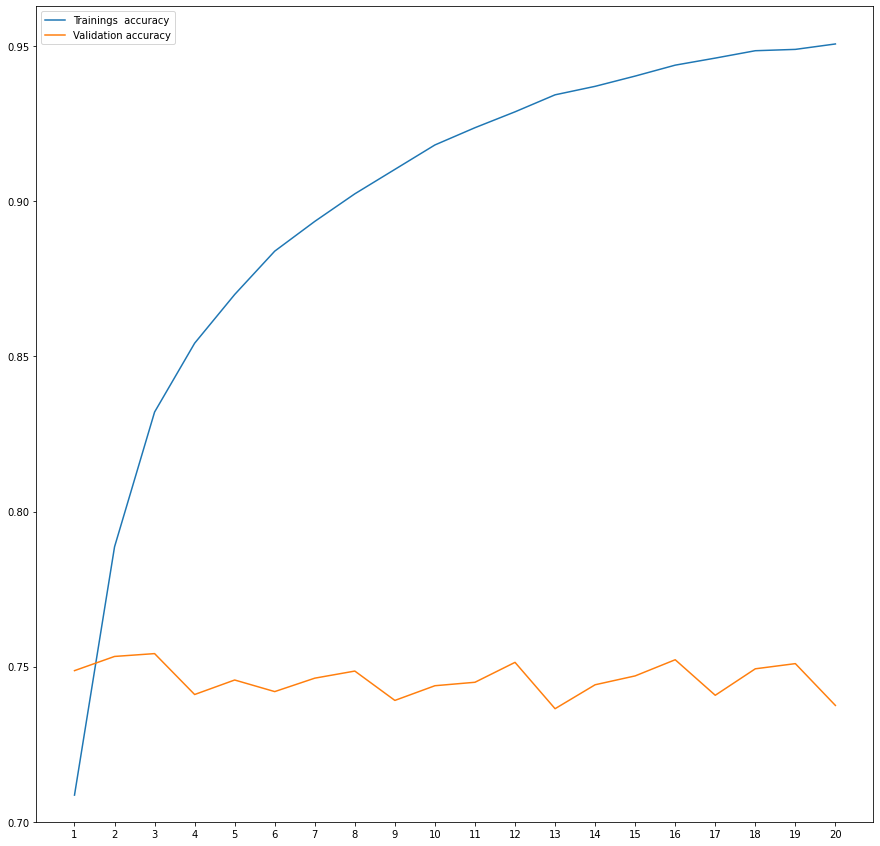

In [28]:
x = np.arange(1,21)

fig, ax = plt.subplots()
ax.plot(x, history.history['accuracy'], label="Trainings  accuracy")
ax.plot(x, history.history['val_accuracy'], label="Validation accuracy")
ax.legend()
ax.set_ylim(ymin=0.7)
ax.set_xticks(x)
plt.show()

Wie sich aus dem Graph herauslesen lässt, ist zum Ende des Trainings des Modelles ein starkes Overfitting vorhanden.
Ab der zweiten Epoche übersteigt die Trainings-Accuracy die Validation-Accuracy.
Bereits nach wenigen Epochen fällt, aufgrund der Überanpassung, die Validation-Accuracy ab, währen die Trainings-Accuracy weiter steigt.
Deshalb ist es sinnvoll, die Anzahl der Epochen zu reduzieren, und anschließend ein neu erstellte Model mit der verringerten Anzahl von Epochen neu zu trainieren.

Im folgenden Code-Abschnitt wird aus diesem Grund die ideale Anzahl der Epochen extrahiert.

In [29]:
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print(f"Optimale Anzahl der Epochen: {best_epoch}")

Optimale Anzahl der Epochen: 3


## Erneutes Bauen und Training des Modelles mit der optimalen Epochen-Anzahl

In [30]:
model = tuner.hypermodel.build(best_hps)
history = model.fit([q1_train, q2_train], yTrain,
                    validation_data = ((q1_valid, q2_valid), yValid),
                    epochs = best_epoch,
                    batch_size = 2048,
)

Epoch 1/3


2022-03-19 15:52:05.619630: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 46573776 exceeds 10% of free system memory.


158/158 [==============================] - 23s 133ms/step - loss: 0.5553 - accuracy: 0.7156 - val_loss: 0.5088 - val_accuracy: 0.7526
Epoch 2/3
158/158 [==============================] - 20s 125ms/step - loss: 0.4400 - accuracy: 0.7916 - val_loss: 0.4978 - val_accuracy: 0.7628
Epoch 3/3
158/158 [==============================] - 21s 131ms/step - loss: 0.3714 - accuracy: 0.8285 - val_loss: 0.5406 - val_accuracy: 0.7605


### Speicherung des Modelles
Nach dem Training erfolgt die Speicherung des gewonnenen Modelles.
Es erfolgt auch eine Speicherung des erstellten Dictionaries mit allen Fragen des Trainingsdatensets, sowie eine Speicherung des Tokenizers.

Diese Speicherung ist notwendig, um diese Komponenten bei der Erstellung der Applikation zur Vorhersage von Fragen zu nutzen.

In [40]:
import os
if not os.path.exists('models'):
    os.mkdir('models')

model.save('models/kaggle.h5')

np.save('models/questions.npy', completeQuestionsDict)

import json
tokenizer_json = tokenizer.to_json()
with open('models/tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

### Evaluation anhand der Geanuigkeit des Modelels
In der folgenden Funktion wird die genauigkeit des Modelles bestimmt.
Die Bestimmung der Genauigkeit erfolgt auf das Trainingsdatenset, das Validierungsdatenset als auch das Testdatenset

In [41]:
trainings_eval = model.evaluate([q1_train, q2_train], yTrain, batch_size=2048)
print(f'Trainings acc: {trainings_eval[1]}')
valid_eval = model.evaluate([q1_valid, q2_valid], yValid, batch_size=2048)
print(f'Validation acc: {valid_eval[1]}')
test_results = model.evaluate([q1_test, q2_test], target_test, batch_size=2048)
print(f'Test acc : {test_results[1]}')

158/158 [==============================] - 4s 26ms/step - loss: 0.4124 - accuracy: 0.8067
Trainings acc: 0.8066994547843933
40/40 [==============================] - 1s 24ms/step - loss: 0.4998 - accuracy: 0.7602
Validation acc: 0.76019686460495
1146/1146 [==============================] - 30s 26ms/step - loss: 1.5629 - accuracy: 0.1588
Test acc : 0.15883177518844604


Es fällt auf, dass bei der Evaluation des Modelles anhand der Trainingsdaten eine sehr schlechte Accuracy erreicht wurde.
Dies mag auf ein schlechtes Modell zurückzuführen, welches jedoch entgegend der vergleichsweisen sehr guten Validation-Accuracy spricht.
Es mag zwar Unterschiede geben da die Validation-Accuracy ausschlaggebend beim Suchen der Hyperparameter waren, jedoch ließe sich dadurch keine so hohe Abweichung erklären.

#### Evaluierung des Testdatensatzes
Bei der vorhergehenden Betrachtung des Testdatensets und seiner Label war auffällig, das sämtliche Fragepaarungen das Label 1 besitzen.
Bei der händischen Betrachtung der Fragenpaarungen des Testdatensatzes fällt jedoch auf, das viele Fragen keine oder nur eine sehr geringe sinnliche Ähnlichkeit besitzen.
Auch besitzen die Fragen teilweise eine sehr schlechte grammatikalische Qualität, was weiterhin zu Fehlklassifizierung führen kann.

Im folgenden finden sich Beispiele, bei denen die Klassifizierung mit dem Label 1 schlicht fehlerhaft ist.
```
58,"Why is glass a green in color?","What color say?"
122,"Is petroleum a mineral? If weight why?","Why mineral?"
129,"What is way?","What card good surrealism from bad surrealism?"
138,"Vit vs nirma?","Why do you create a blog?"
```
Bei anderen Fragepaarungen hängt die Klassifizierung mit dem Label 1 stark von der bewertenden Person ab.
So kann zwar bei der Fragepaarung `151,"How do I hide famous followers?","How can I the identity of a follower on Instagram?"` ein Zusammenhang in den Themen Instagram und Follower erkannt werden.
Jedoch mag der Sinn der Frage unterschiedlich sein, da es zum einem um das verstecken von berühmenten Followern und auf der anderen Seite um die Erkennung der Identität eines Followers geht.

Aus diesem Grund ist die Test-Accuracy mit Vorsicht zu betrachten
#### Auswertung der Klassifizierung
Stattdessen wurde sich dafür entschieden, eine reine Klassifizierung der Testdaten durchzuführen und diese entsprechend darzustellen.

Es wurde sich dazu entschieden, dass bei einer Entscheidung von einem Duplication-Score von über 0.5 die entsprechende Fragepaarung mit dem Label 1 und damit als sinnlich verwandt einzustufen ist.

In [19]:
test = model.predict([q1_test, q2_test], batch_size = 2048, verbose = 1, use_multiprocessing = True)
test_labels = np.where(test > 0.5, 1, 0)
dist = np.unique(test_labels, return_counts=True)

   5/1146 [..............................] - ETA: 32s

2022-03-18 15:31:51.013112: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1146/1146 [==============================] - 27s 21ms/step


In [20]:
print(f"Percentage of 0 labels in test-data: {dist[1][0] / len(test.flatten())}")
print(f"Percentage of 1 labels in test-data: {dist[1][1] / len(test.flatten())}")

Percentage of 0 labels in test-data: 0.8411682205141978
Percentage of 1 labels in test-data: 0.15883177948580224


Text(0.5, 1.0, 'Labels distribute from the prediction for the test-dataset')

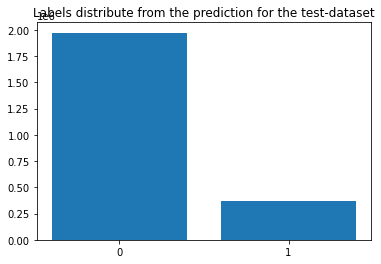

In [22]:
fig, ax = plt.subplots()
#abel_dist = df_train.is_duplicate.value_counts()

ax.bar([0,1],[dist[1][0], dist[1][1]])
ax.set_xticks([0,1], labels=[0,1])
ax.set_title('Labels distribute from the prediction for the test-dataset')

### Trainieren und Evaluierung des Modelles mit dem Trainingsdatensatz aufgeteilt in Trainigs-, Validierungs und Testdaten.
Um das trainierte Model besser auch anhand Trainingsdaten bewerten zu können, wird im abschließend Code-Abschnitt.

Dabei wird das Model mit den ermittelten optimalen Parametern erstellt und anschließend mit den definierten Trainingsdaten trainiert. Dabei werden 15% der Trainingsdaten als Validierungsdaten.

Bei der anschließenden Evaluierung wird der Datensatz, welcher im vorherigen Model noch als Validierungsdaten benutzt wurde, als Testdatensatz verwendet.
Dieser entspricht damit 20% der eingelesenen Daten der Datei

#### Erstellung und Training des Model

In [31]:
model = tuner.hypermodel.build(best_hps)
history = model.fit([q1_train, q2_train], yTrain,
                    validation_split=0.2,
                    epochs = best_epoch,
                    batch_size = 2048,
)

Epoch 1/3
127/127 [==============================] - 20s 138ms/step - loss: 0.5630 - accuracy: 0.7063 - val_loss: 0.4991 - val_accuracy: 0.7627
Epoch 2/3
127/127 [==============================] - 17s 136ms/step - loss: 0.4255 - accuracy: 0.8023 - val_loss: 0.4934 - val_accuracy: 0.7731
Epoch 3/3
127/127 [==============================] - 17s 135ms/step - loss: 0.2965 - accuracy: 0.8691 - val_loss: 0.5644 - val_accuracy: 0.7416


#### Evaluierung des Modelles

In [32]:
trainings_eval = model.evaluate([q1_train, q2_train], yTrain, batch_size=2048)
print(f'Trainings acc: {trainings_eval[1]}')
test_eval = model.evaluate([q1_valid, q2_valid], yValid, batch_size=2048)
print(f'Test acc: {test_eval[1]}')

158/158 [==============================] - 4s 25ms/step - loss: 0.2914 - accuracy: 0.8789
Trainings acc: 0.878903865814209
40/40 [==============================] - 1s 21ms/step - loss: 0.5657 - accuracy: 0.7405
Test acc: 0.7404956817626953


Es ergibt sich, dass die Accuracy des Testdatensatzes ungefähr der Accuracy des Validierungsdatensatzes ähnelt.

#### Bewertung der Ergebnisse des Modelles
Durch die Erstellung des Modelles und der Evalierung des Modelles mit eigens gewählten Testdaten lässt sich die Theorie der mangelhafen Testdaten aus `test.csv` bestätigen.

Es ist in der Tat davon auszugehen, das es sich bei der Kennzeichnung mit dem Label `1` für jede Fragenpaarung aus dem Testdatensatz um ein fehlerhafte Kennzeichnung handelt.
Deshalb gilt nach wie vor, dass die Evaluierung des Testdatensatzes aus `test.csv` mit Skepsis zu betrachten ist.
Die daraus gewonnene Accuracy ist daher nicht wirklich ausschlaggebend.



#### Laden des Modells, um ein erneutes Training zu verhindern

In [18]:
model = tf.keras.models.load_model('./models/kaggle.h5')

2022-03-18 15:29:22.754377: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-18 15:29:22.845941: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-18 15:29:22.846135: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-18 15:29:22.847542: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [ ]:
def getPrediction(question1, question2):
    test1 = tokenizer.texts_to_sequences(list([question1]))
    test1 = pad_sequences(test1, maxlen = 36, padding = 'post')
    test2 = tokenizer.texts_to_sequences(list([question2]))
    test2 = pad_sequences(test2, maxlen = 36, padding = 'post')
    predict = model.predict([test1, test2])
    return predict


In [ ]:
getPrediction("What was your first sexual experience like?", "What was your first sexual experience like?")

# Implementierung in ein Frontend
## Erstellung einer Funktion, welche aus einer Benutzereingab 3 Fragen vorschlägt
Im folgend erfolgt die Definition einer Funktion, welche ähnliche Fragen vorschlägt.
Dabei wird neben der Frage des Benutzers das trainierte Model, sowie der Tokenizer und die Sammlung von Fragen aus den Trainingsdaten übergeben

Anschließend wird für jede Frage aus dem gesammlten Fragenkatalog der Fragen aus `train.csv` der entsprechende "Übereinstimmungs"-Wert ermittelt.
Die 5 Fragen mit dem höchsten Wert werden durch den Tokenizer zurück in den entsprechenden String umgewandelt, und anschließend als Rückgabe der Funktion zurückgegeben.

In [ ]:
def getTopThreeQuestions(user_question):
    found_questions = []
    encoded_user_question = tokenizer.texts_to_sequences([user_question])
    encoded_user_question = pad_sequences(encoded_user_question, maxlen = 36, padding = 'post')
    something = np.asarray([encoded_user_question[0]]*len(completeQuestionsDict))
    test = model.predict([something, completeQuestionsDict], batch_size = 4096, verbose = 1, use_multiprocessing = True)
    print(np.sort(test.flatten()))
    a = test.flatten()
    ind = np.argpartition(a, -5)[-5:]
    top3 = ind
    print(top3)
    for item in top3:
        decoded_question = tokenizer.sequences_to_texts([completeQuestionsDict[item]])[0]
        found_questions.append(decoded_question)
    return found_questions

In [ ]:
foundQuestions = getTopThreeQuestions("What was the significance of the battle of Somme, and how did this battle compare and contrast to the Battle of Rostov?")
for i, question in enumerate(foundQuestions):
    print(f"Question {i}")
    print(question)

### Erstellung eines Webservers
Es wurde ein Webserver mit einem einfachen Frontend erstellt. Dieser bekommt ein Frage, und schlägt daraufhin ähnliche Fragen vor